# Enhanced Human Detection in Flood Images

**Usage**
- YOLOv11
- data augmentation for flood scenarios
- Advanced training strategies
- Comprehensive evaluation metrics
- Visualization and analysis tools

## 1. Setup and Installation

In [2]:
!pip install -q ultralytics kagglehub opencv-python-headless
!pip install -q seaborn scikit-learn

import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from IPython.display import display, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

random.seed(42)
np.random.seed(42)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.0 MB/s eta 0:00:00
✓ Packages installed successfully!


## 2. Download Dataset using KaggleHub

In [4]:
import kagglehub

print("Downloading C2A dataset...")
path = kagglehub.dataset_download("rgbnihal/c2a-dataset")
print(f" Dataset downloaded to: {path}")

dataset_base = Path(path)
print(f"\nExploring dataset structure...")
for item in dataset_base.rglob('*'):
    if item.is_dir():
        print(f"  {item.relative_to(dataset_base)}/")

100%|██████████| 4.57G/4.57G [03:29<00:00, 23.5MB/s]

Extracting files...


✓ Dataset downloaded to: /root/.cache/kagglehub/datasets/rgbnihal/c2a-dataset/versions/2

Exploring dataset structure...
  Coco_annotation_pose/
  C2A_Dataset/
  C2A_Dataset/new_dataset3/
  C2A_Dataset/new_dataset3/val/
  C2A_Dataset/new_dataset3/test/
  C2A_Dataset/new_dataset3/train/
  C2A_Dataset/new_dataset3/All labels with Pose information/
  C2A_Dataset/new_dataset3/val/labels/
  C2A_Dataset/new_dataset3/val/images/
  C2A_Dataset/new_dataset3/test/labels/
  C2A_Dataset/new_dataset3/test/images/
  C2A_Dataset/new_dataset3/train/labels/
  C2A_Dataset/new_dataset3/train/images/
  C2A_Dataset/new_dataset3/All labels with Pose information/labels/


## 3. Data Preparation and Analysis

In [5]:
base_path = Path(path) / "C2A_Dataset" / "new_dataset3"

if not base_path.exists():
    print("Searching for correct dataset path...")
    for candidate in Path(path).rglob('new_dataset3'):
        if candidate.is_dir():
            base_path = candidate
            break
    if not base_path.exists():
        for candidate in Path(path).rglob('train'):
            if (candidate.parent / 'val').exists():
                base_path = candidate.parent
                break

print(f"Using dataset path: {base_path}")

train_img_dir = base_path / "train" / "images"
train_lbl_dir = base_path / "train" / "labels"
val_img_dir = base_path / "val" / "images"
val_lbl_dir = base_path / "val" / "labels"

for p in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
    assert p.exists(), f"Path not found: {p}"
print(" All dataset paths verified!")

Using dataset path: /root/.cache/kagglehub/datasets/rgbnihal/c2a-dataset/versions/2/C2A_Dataset/new_dataset3
✓ All dataset paths verified!


In [ ]:
def analyze_dataset(img_dir, lbl_dir, split_name):
    all_images = list(img_dir.glob('*.png')) + list(img_dir.glob('*.jpg'))
    flood_images = [f for f in all_images if f.name.startswith('flood_image')]

    total_humans = 0
    images_with_humans = 0
    humans_per_image = []

    for img_file in flood_images:
        lbl_file = lbl_dir / f"{img_file.stem}.txt"
        if lbl_file.exists():
            with open(lbl_file, 'r') as f:
                lines = f.readlines()
                num_humans = len(lines)
                if num_humans > 0:
                    images_with_humans += 1
                    total_humans += num_humans
                    humans_per_image.append(num_humans)

    print(f"\n{'='*50}")
    print(f"  {split_name.upper()} SET STATISTICS")
    print(f"{'='*50}")
    print(f"Total flood images: {len(flood_images)}")
    print(f"Images with humans: {images_with_humans}")
    print(f"Total human instances: {total_humans}")
    print(f"Avg humans per image: {np.mean(humans_per_image):.2f}" if humans_per_image else "N/A")
    print(f"Max humans in image: {max(humans_per_image)}" if humans_per_image else "N/A")
    print(f"Min humans in image: {min(humans_per_image)}" if humans_per_image else "N/A")

    return flood_images, humans_per_image

flood_train_imgs, train_dist = analyze_dataset(train_img_dir, train_lbl_dir, "train")
flood_val_imgs, val_dist = analyze_dataset(val_img_dir, val_lbl_dir, "validation")


  TRAIN SET STATISTICS
Total flood images: 1529
Images with humans: 1529
Total human instances: 52170
Avg humans per image: 34.12
Max humans in image: 72
Min humans in image: 17

  VALIDATION SET STATISTICS
Total flood images: 542
Images with humans: 542
Total human instances: 18562
Avg humans per image: 34.25
Max humans in image: 72
Min humans in image: 17


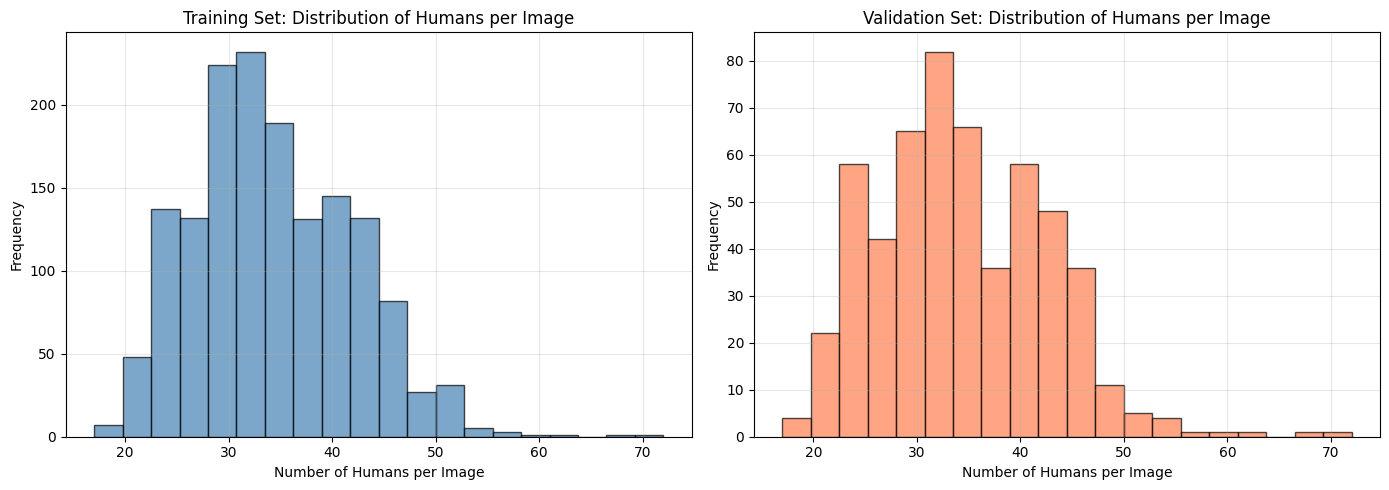

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_dist, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Humans per Image')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Training Set: Distribution of Humans per Image')
axes[0].grid(True, alpha=0.3)

axes[1].hist(val_dist, bins=20, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of Humans per Image')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Validation Set: Distribution of Humans per Image')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Create Filtered Flood Dataset

In [9]:
work_dir = Path("/content/flood_yolo")
for subdir in ["images/train", "images/val", "labels/train", "labels/val"]:
    (work_dir / subdir).mkdir(parents=True, exist_ok=True)

print("Copying flood images and labels...")

for img_file in flood_train_imgs:
    lbl_file = train_lbl_dir / f"{img_file.stem}.txt"
    dst_img = work_dir / "images" / "train" / img_file.name
    dst_lbl = work_dir / "labels" / "train" / lbl_file.name
    shutil.copy(img_file, dst_img)
    if lbl_file.exists():
        shutil.copy(lbl_file, dst_lbl)

for img_file in [val_img_dir / f.name for f in flood_val_imgs]:
    lbl_file = val_lbl_dir / f"{img_file.stem}.txt"
    dst_img = work_dir / "images" / "val" / img_file.name
    dst_lbl = work_dir / "labels" / "val" / lbl_file.name
    shutil.copy(img_file, dst_img)
    if lbl_file.exists():
        shutil.copy(lbl_file, dst_lbl)

print(f" Copied {len(flood_train_imgs)} training images")
print(f" Copied {len(flood_val_imgs)} validation images")

Copying flood images and labels...
 Copied 1529 training images
 Copied 542 validation images


In [10]:
dataset_yaml = f"""path: {work_dir}
train: images/train
val: images/val

# Classes
names:
  0: human

# Number of classes
nc: 1
"""

yaml_path = work_dir / "flood.yaml"
with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

print(f" Dataset configuration created at: {yaml_path}")

 Dataset configuration created at: /content/flood_yolo/flood.yaml


## 5. Visualize Sample Images

Sample training images with ground truth boxes:


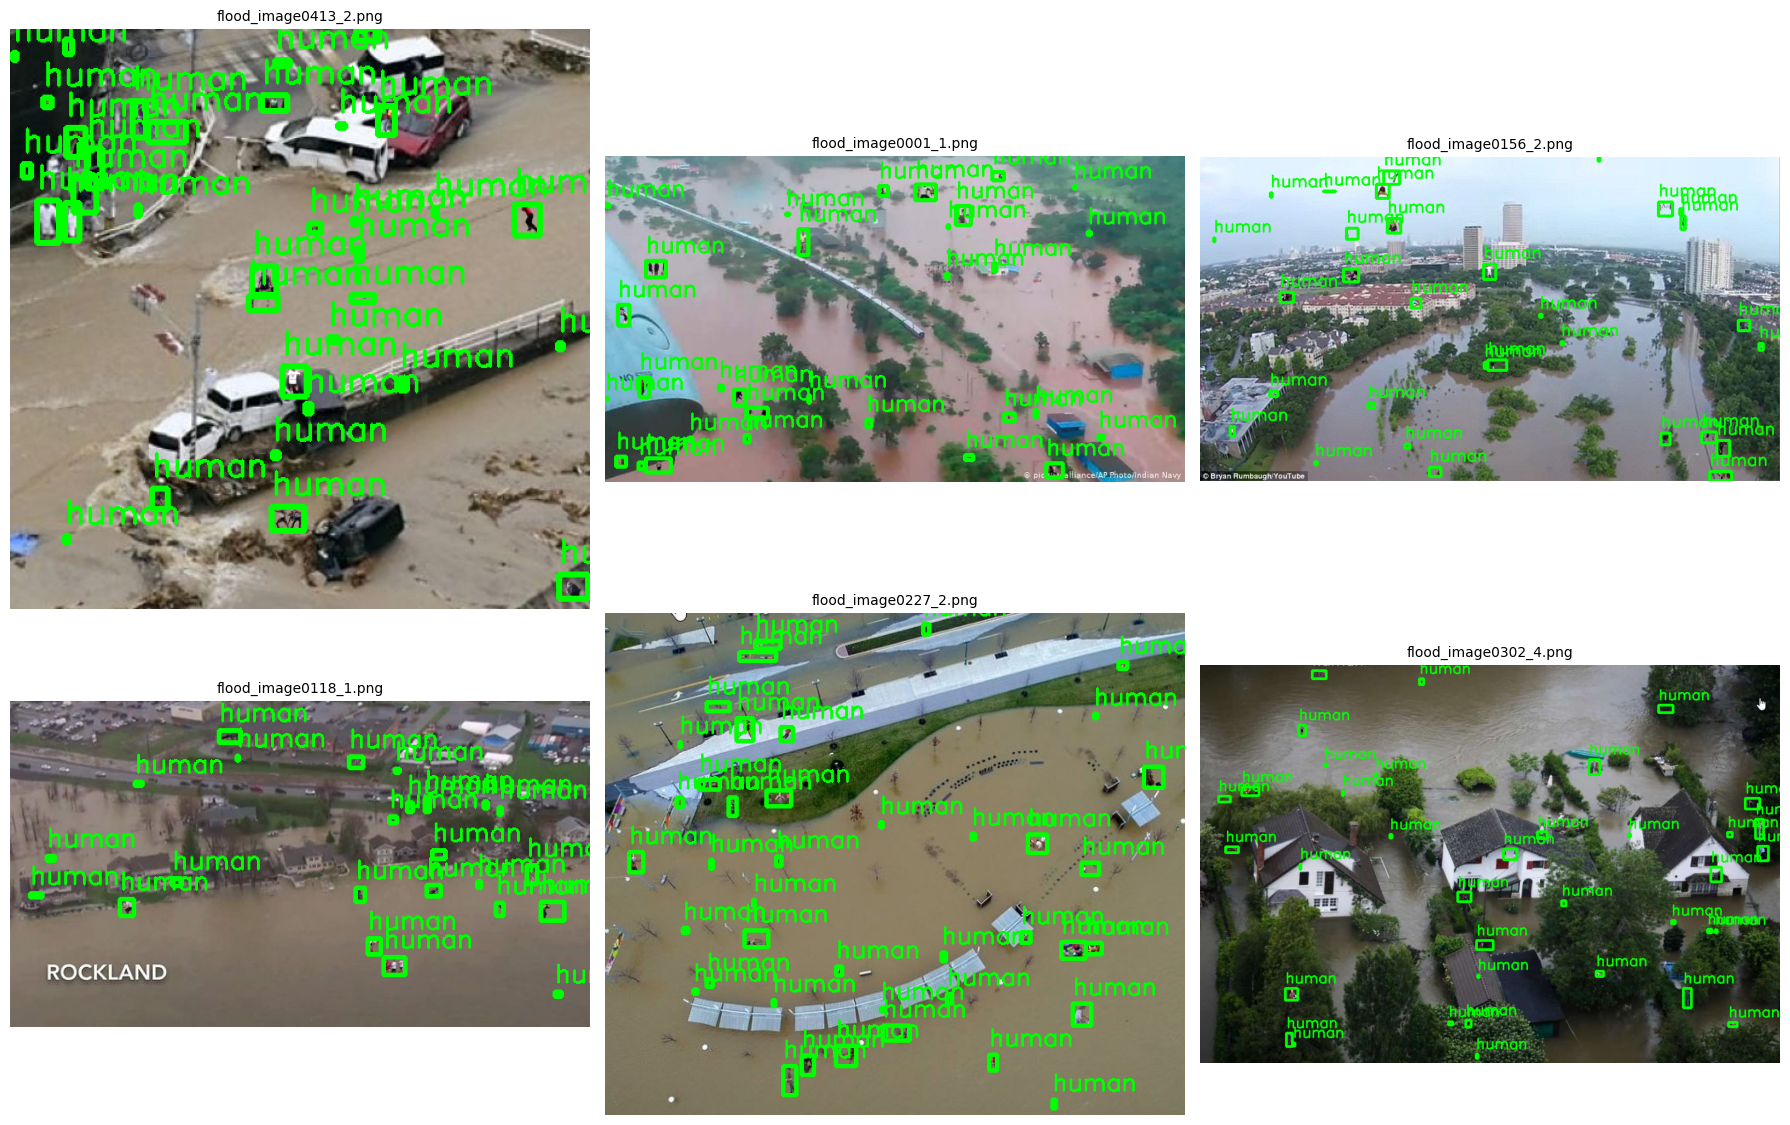

In [11]:
def plot_sample_images(img_dir, lbl_dir, num_samples=6):
    images = list(img_dir.glob('*.png')) + list(img_dir.glob('*.jpg'))
    samples = random.sample(images, min(num_samples, len(images)))

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(samples):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        lbl_path = lbl_dir / f"{img_path.stem}.txt"
        if lbl_path.exists():
            with open(lbl_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        _, x_center, y_center, width, height = map(float, parts[:5])

                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)

                        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                        cv2.putText(img, 'human', (x1, y1-10),
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f"{img_path.name}", fontsize=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

print("Sample training images with ground truth boxes:")
plot_sample_images(work_dir / "images" / "train", work_dir / "labels" / "train")

## 6. Model Training with YOLOv11

Using YOLOv11x - the most accurate variant with better performance than RT-DETR

In [12]:
from ultralytics import YOLO

model = YOLO('yolo11x.pt')

print("Model loaded successfully!")
print(f"Model: YOLOv11x")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model loaded successfully!
Model: YOLOv11x


In [13]:
import torch
torch.cuda.empty_cache()

In [15]:
import gc
import torch

try:
    del model
    del best_model
except:
    pass


gc.collect()


torch.cuda.empty_cache()


torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()

from ultralytics import YOLO


model = YOLO('yolo11s.pt')

print("Model loaded successfully!")
results = model.train(
    data=str(yaml_path),


    epochs=20,
    patience=15,

    batch=64,
    imgsz=640,

    optimizer='SGD',
    lr0=0.01,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=15.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.0,
    copy_paste=0.0,

    box=7.5,
    cls=0.5,
    dfl=1.5,

    close_mosaic=10,
    amp=True,
    fraction=1.0,

    workers=2,
    device=0,
    cache=False,

    save=True,
    save_period=-1,

    plots=True,

    exist_ok=True,
    verbose=True,
    seed=42,
    deterministic=True
)

print("\nTraining completed!")

Model loaded successfully!
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/flood_yolo/flood.yaml, degrees=15.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=15, perspectiv

## 7. Training Results Visualization

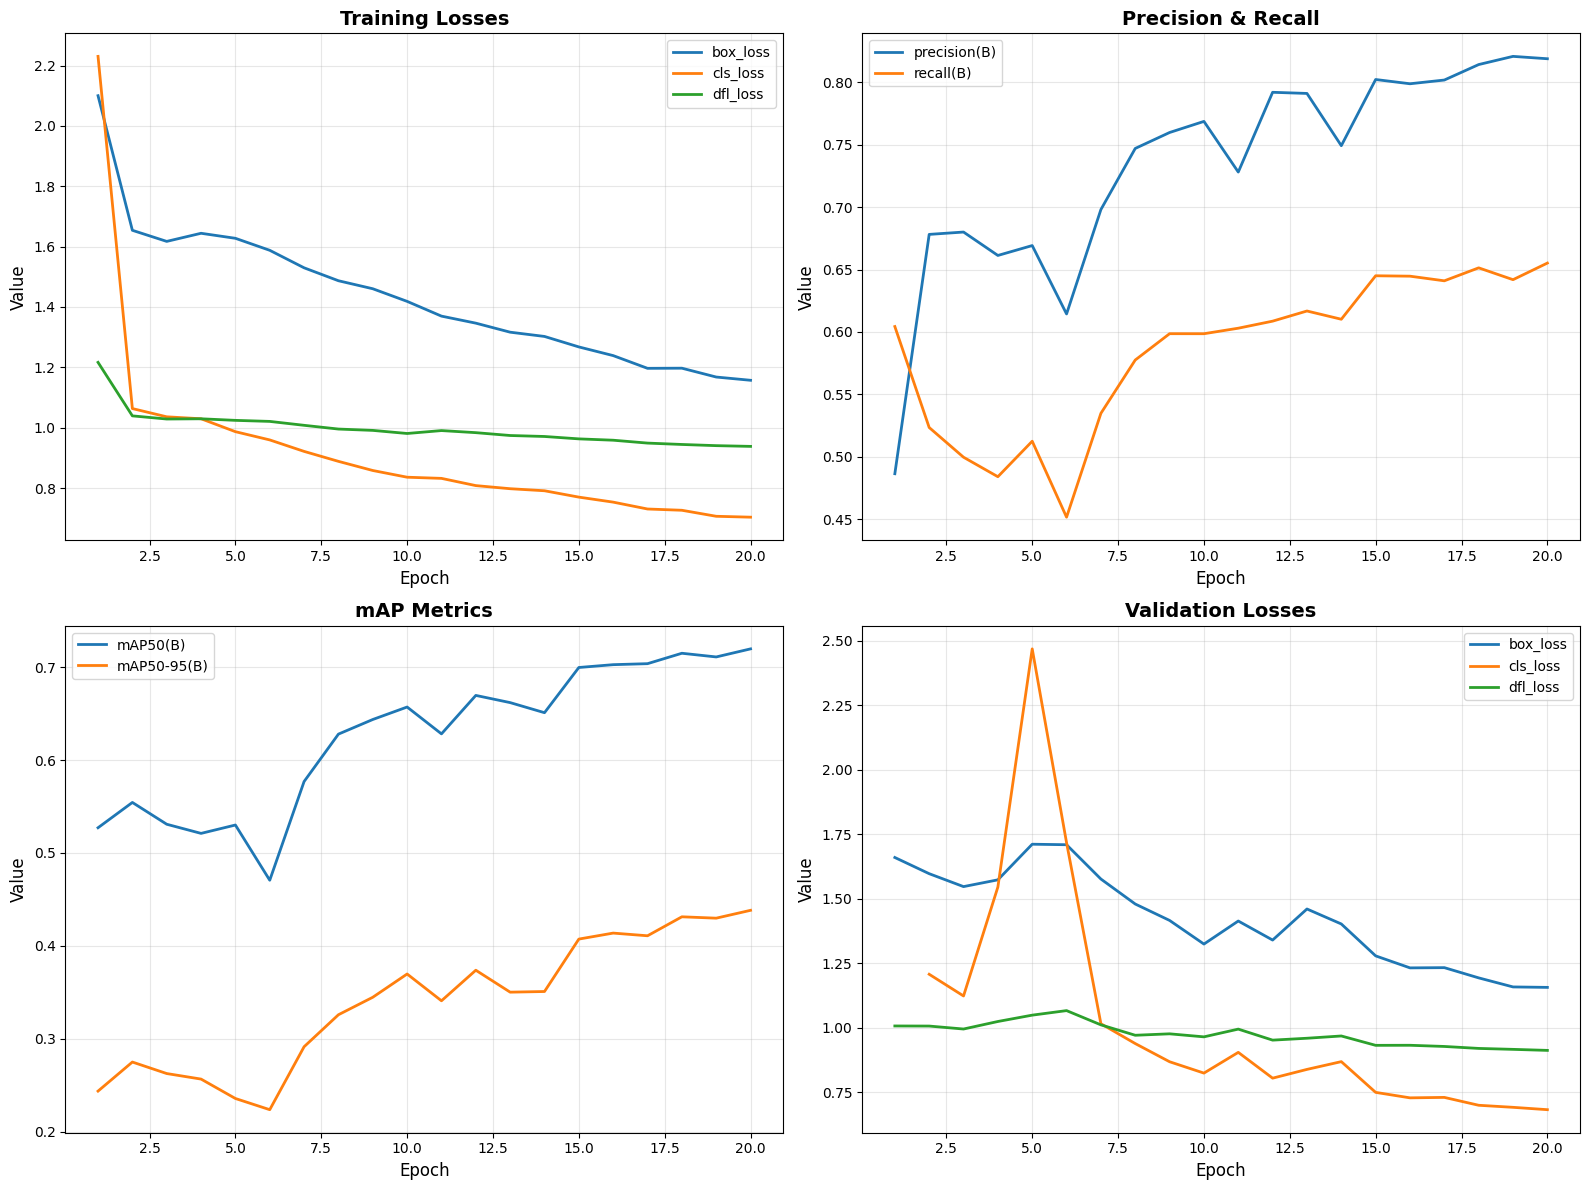


  BEST TRAINING METRICS
Best epoch: 20
Best mAP@0.5: 0.7196
Best mAP@0.5:0.95: 0.4383
Precision: 0.8189
Recall: 0.6552


In [16]:
csv_path = Path(results.save_dir) / "results.csv"

if csv_path.exists():
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    if 'epoch' not in df.columns:
        df.insert(0, 'epoch', range(len(df)))

    metrics_to_plot = [
        ('train/box_loss', 'train/cls_loss', 'train/dfl_loss'),
        ('metrics/precision(B)', 'metrics/recall(B)'),
        ('metrics/mAP50(B)', 'metrics/mAP50-95(B)'),
        ('val/box_loss', 'val/cls_loss', 'val/dfl_loss')
    ]

    titles = [
        'Training Losses',
        'Precision & Recall',
        'mAP Metrics',
        'Validation Losses'
    ]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, (metric_group, title) in enumerate(zip(metrics_to_plot, titles)):
        for metric in metric_group:
            if metric in df.columns:
                axes[idx].plot(df['epoch'], df[metric], label=metric.split('/')[-1], linewidth=2)

        axes[idx].set_xlabel('Epoch', fontsize=12)
        axes[idx].set_ylabel('Value', fontsize=12)
        axes[idx].set_title(title, fontsize=14, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*60)
    print("  BEST TRAINING METRICS")
    print("="*60)

    if 'metrics/mAP50(B)' in df.columns:
        best_idx = df['metrics/mAP50(B)'].idxmax()
        print(f"Best epoch: {df.loc[best_idx, 'epoch']:.0f}")
        print(f"Best mAP@0.5: {df.loc[best_idx, 'metrics/mAP50(B)']:.4f}")
        print(f"Best mAP@0.5:0.95: {df.loc[best_idx, 'metrics/mAP50-95(B)']:.4f}")
        print(f"Precision: {df.loc[best_idx, 'metrics/precision(B)']:.4f}")
        print(f"Recall: {df.loc[best_idx, 'metrics/recall(B)']:.4f}")
else:
    print("Results CSV not found!")

Training result visualizations:

📊 results.png


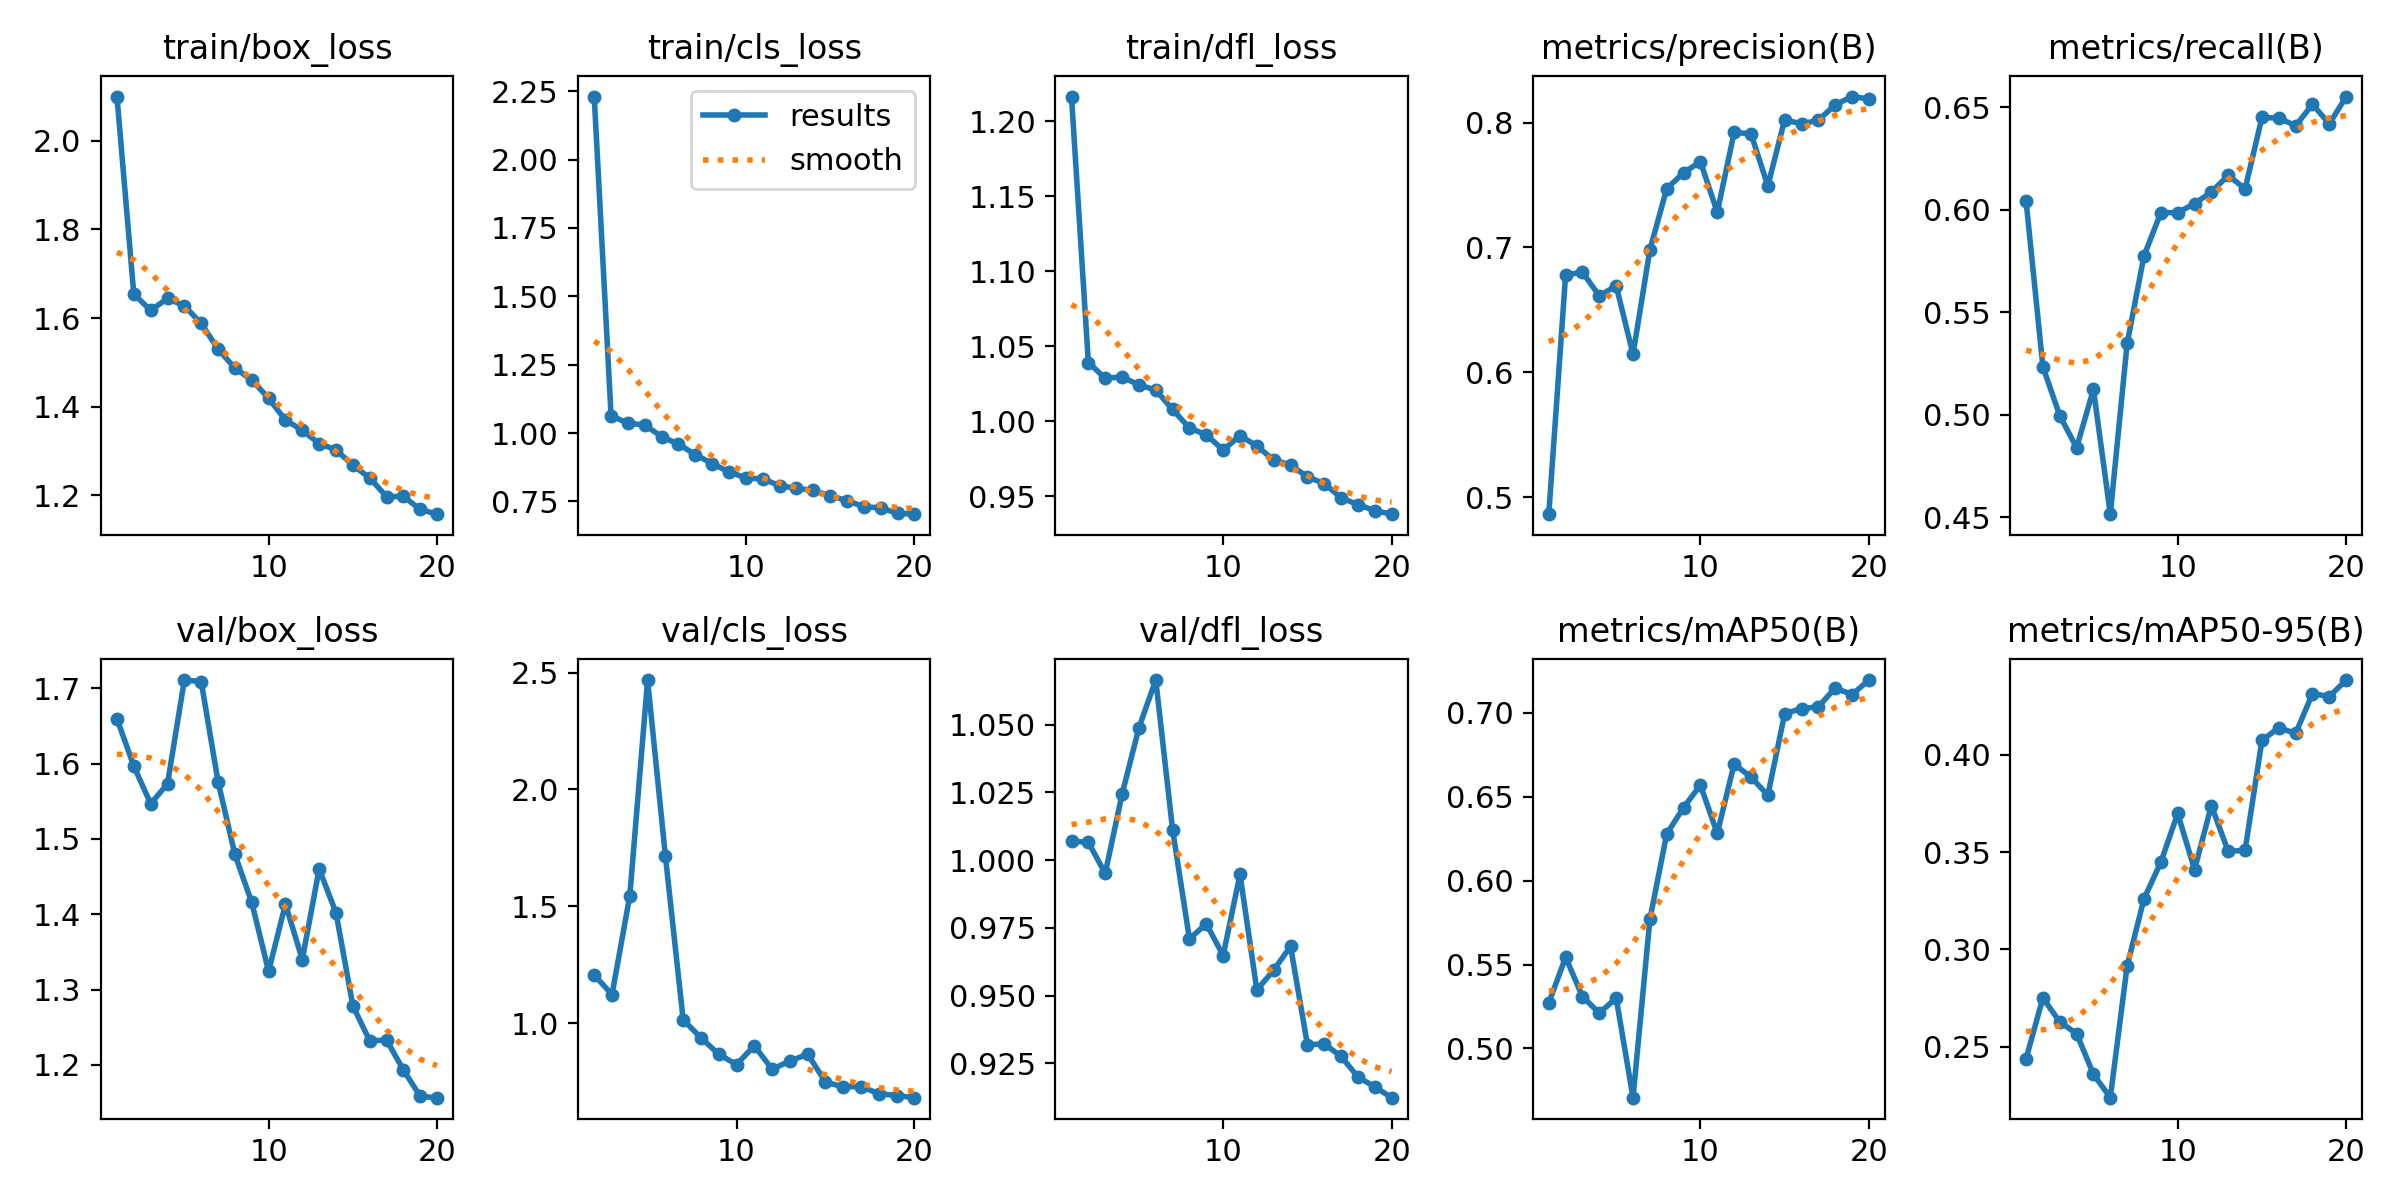

📊 confusion_matrix.png


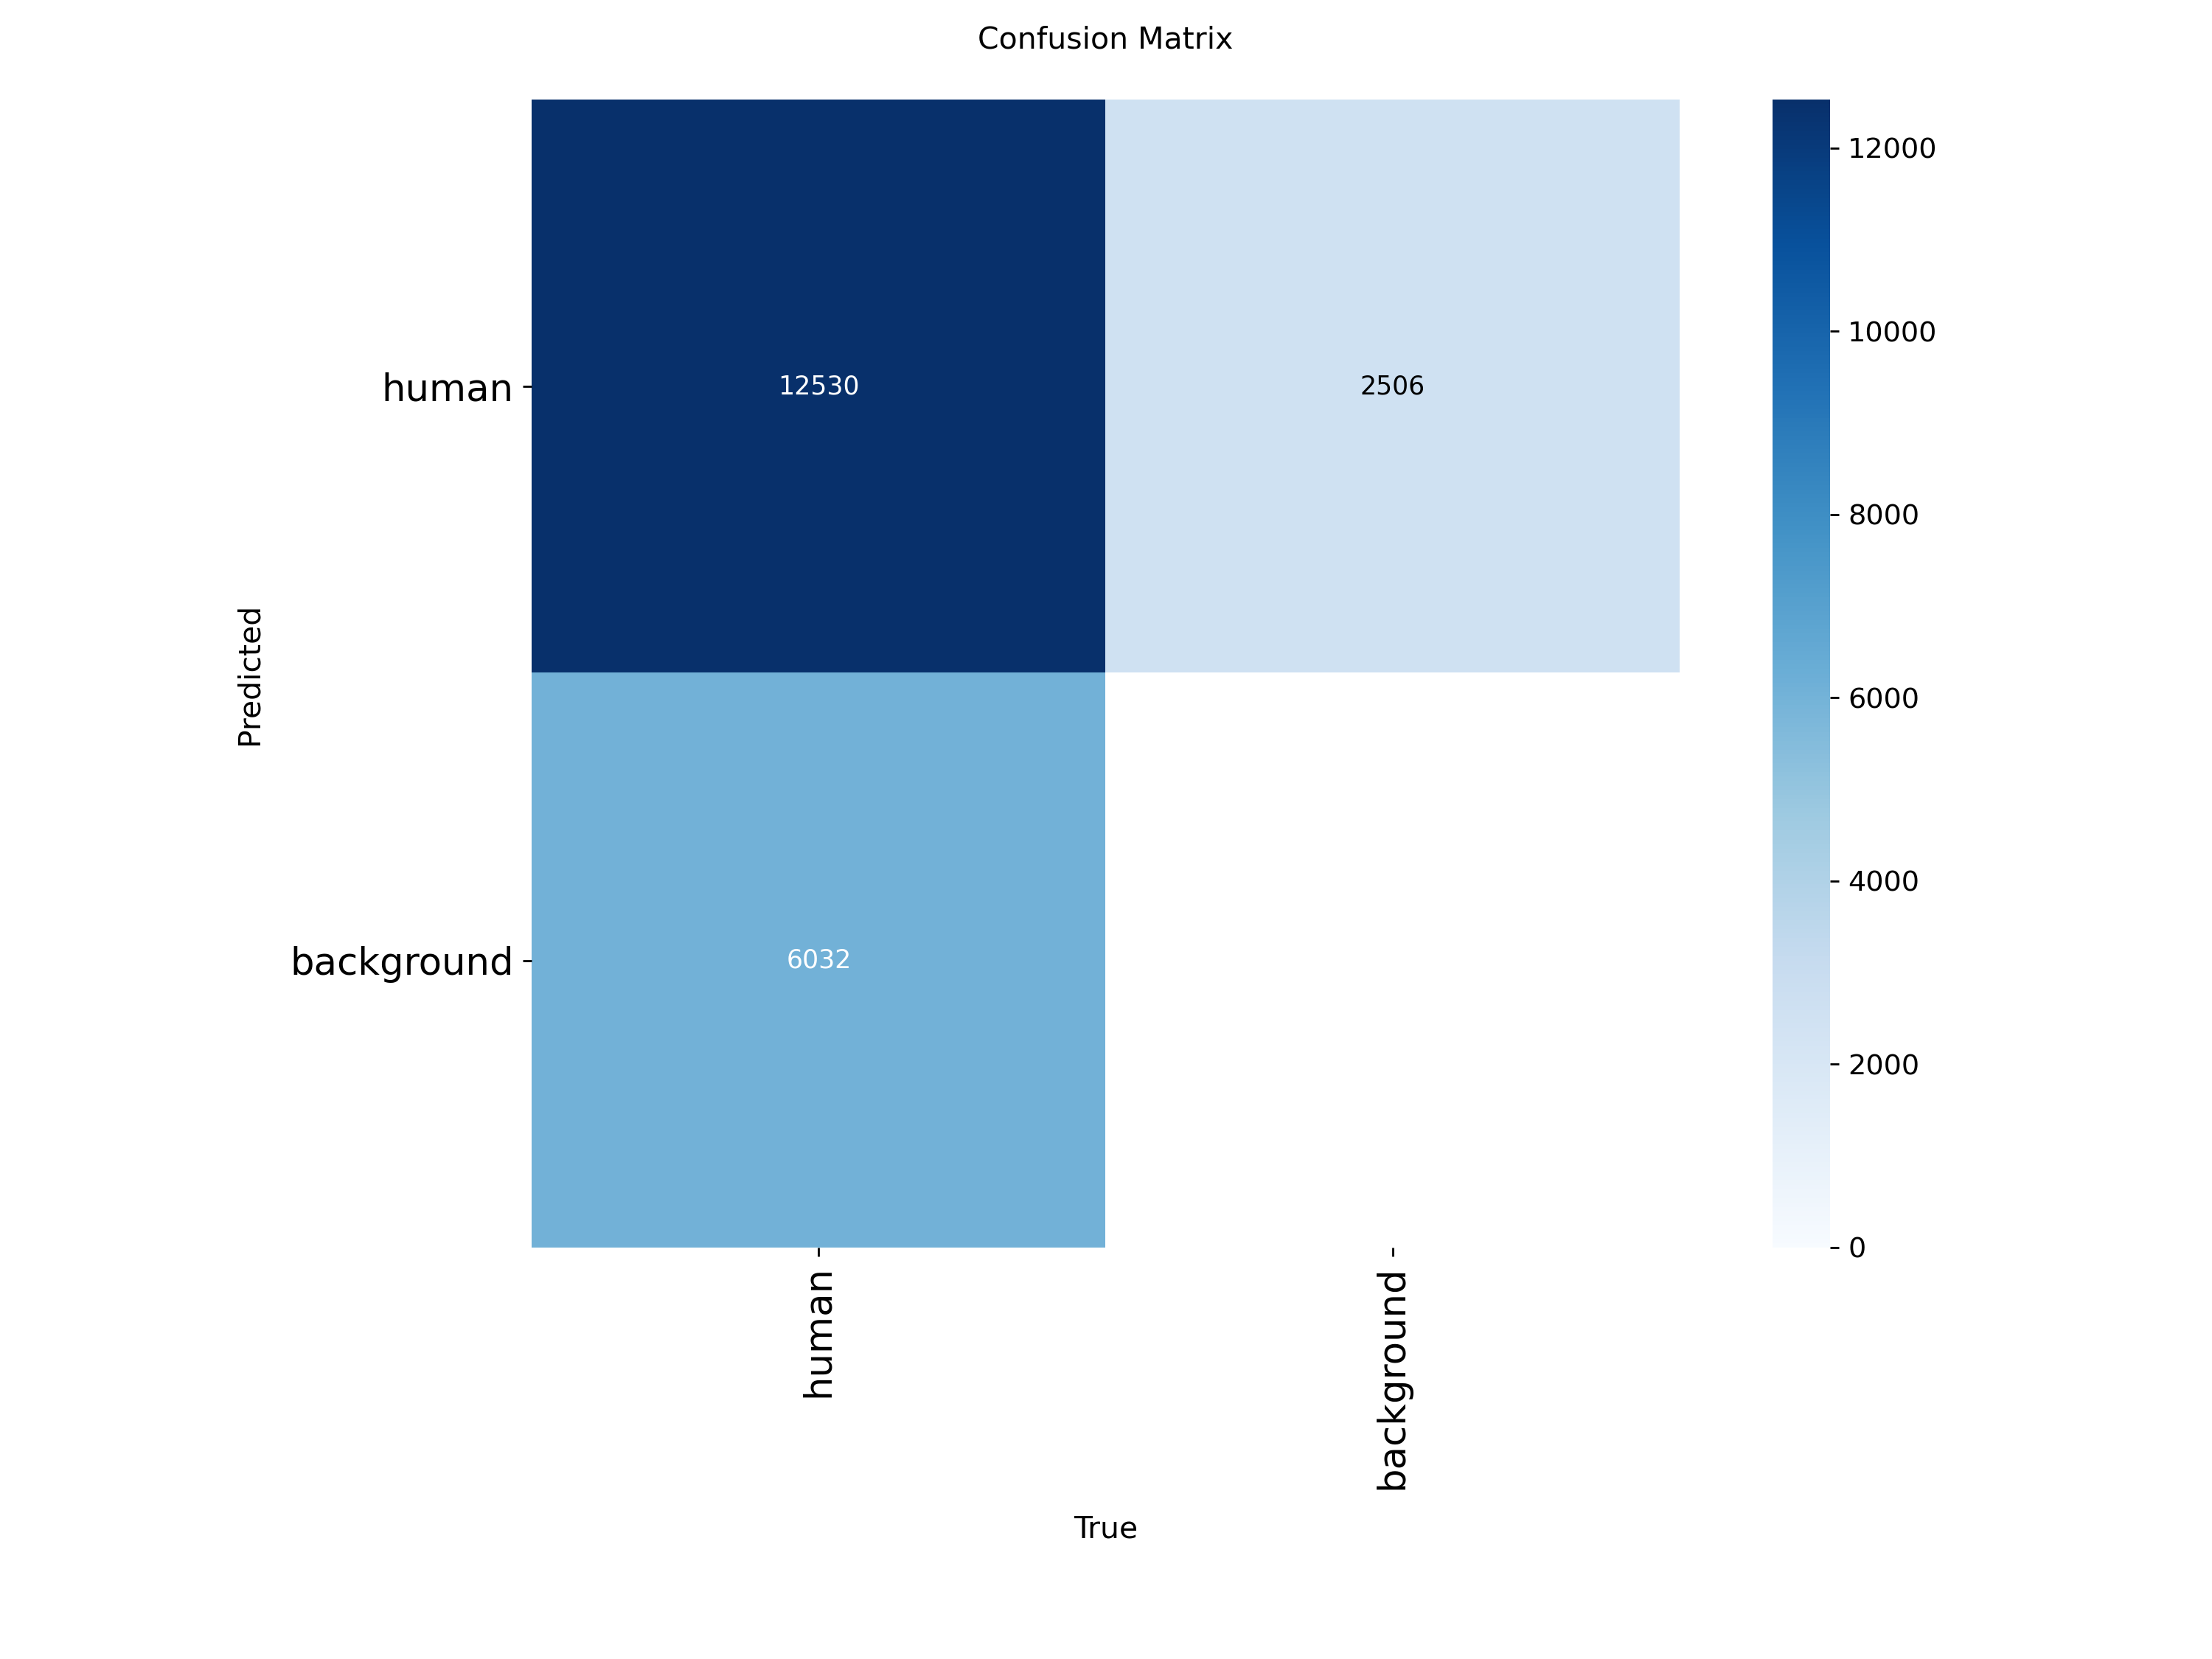

In [17]:
results_dir = Path(results.save_dir)

print("Training result visualizations:\n")

for plot_name in ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png', 'P_curve.png', 'R_curve.png']:
    plot_path = results_dir / plot_name
    if plot_path.exists():
        print(f"📊 {plot_name}")
        display(IPImage(filename=str(plot_path)))

## 8. Save Best Model

In [18]:
best_model_path = Path(results.save_dir) / "weights" / "best.pt"
output_model_path = Path("/content/flood_yolov11_best.pt")

shutil.copy(best_model_path, output_model_path)
print(f"Best model saved to: {output_model_path}")
print(f"Model size: {output_model_path.stat().st_size / (1024*1024):.2f} MB")

Best model saved to: /content/flood_yolov11_best.pt
Model size: 18.28 MB


## 9. Model Evaluation

In [19]:
best_model = YOLO(str(output_model_path))

print("Running validation on test set...\n")
val_results = best_model.val(
    data=str(yaml_path),
    split='val',
    imgsz=1280,
    batch=8,
    conf=0.001,
    iou=0.6,
    plots=True,
    save_json=True,
    verbose=True
)

print("\n" + "="*60)
print("  VALIDATION METRICS")
print("="*60)
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")
print(f"mAP@0.5: {val_results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {val_results.box.map:.4f}")
print(f"F1-Score: {2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr + 1e-8):.4f}")
print("="*60)

Running validation on test set...

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3627.5±620.6 MB/s, size: 534.2 KB)
val: Scanning /content/flood_yolo/labels/val.cache... 542 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 542/542 873.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 4.3it/s 16.0s
                   all        542      18562      0.847      0.783      0.833      0.561
Speed: 2.3ms preprocess, 16.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Saving /content/runs/detect/val/predictions.json...
Results saved to /content/runs/detect/val

  VALIDATION METRICS
Precision: 0.8472
Recall: 0.7827
mAP@0.5: 0.8326
mAP@0.5:0.95: 0.5613
F1-Score: 0.8137


## 10. Inference on Validation Samples

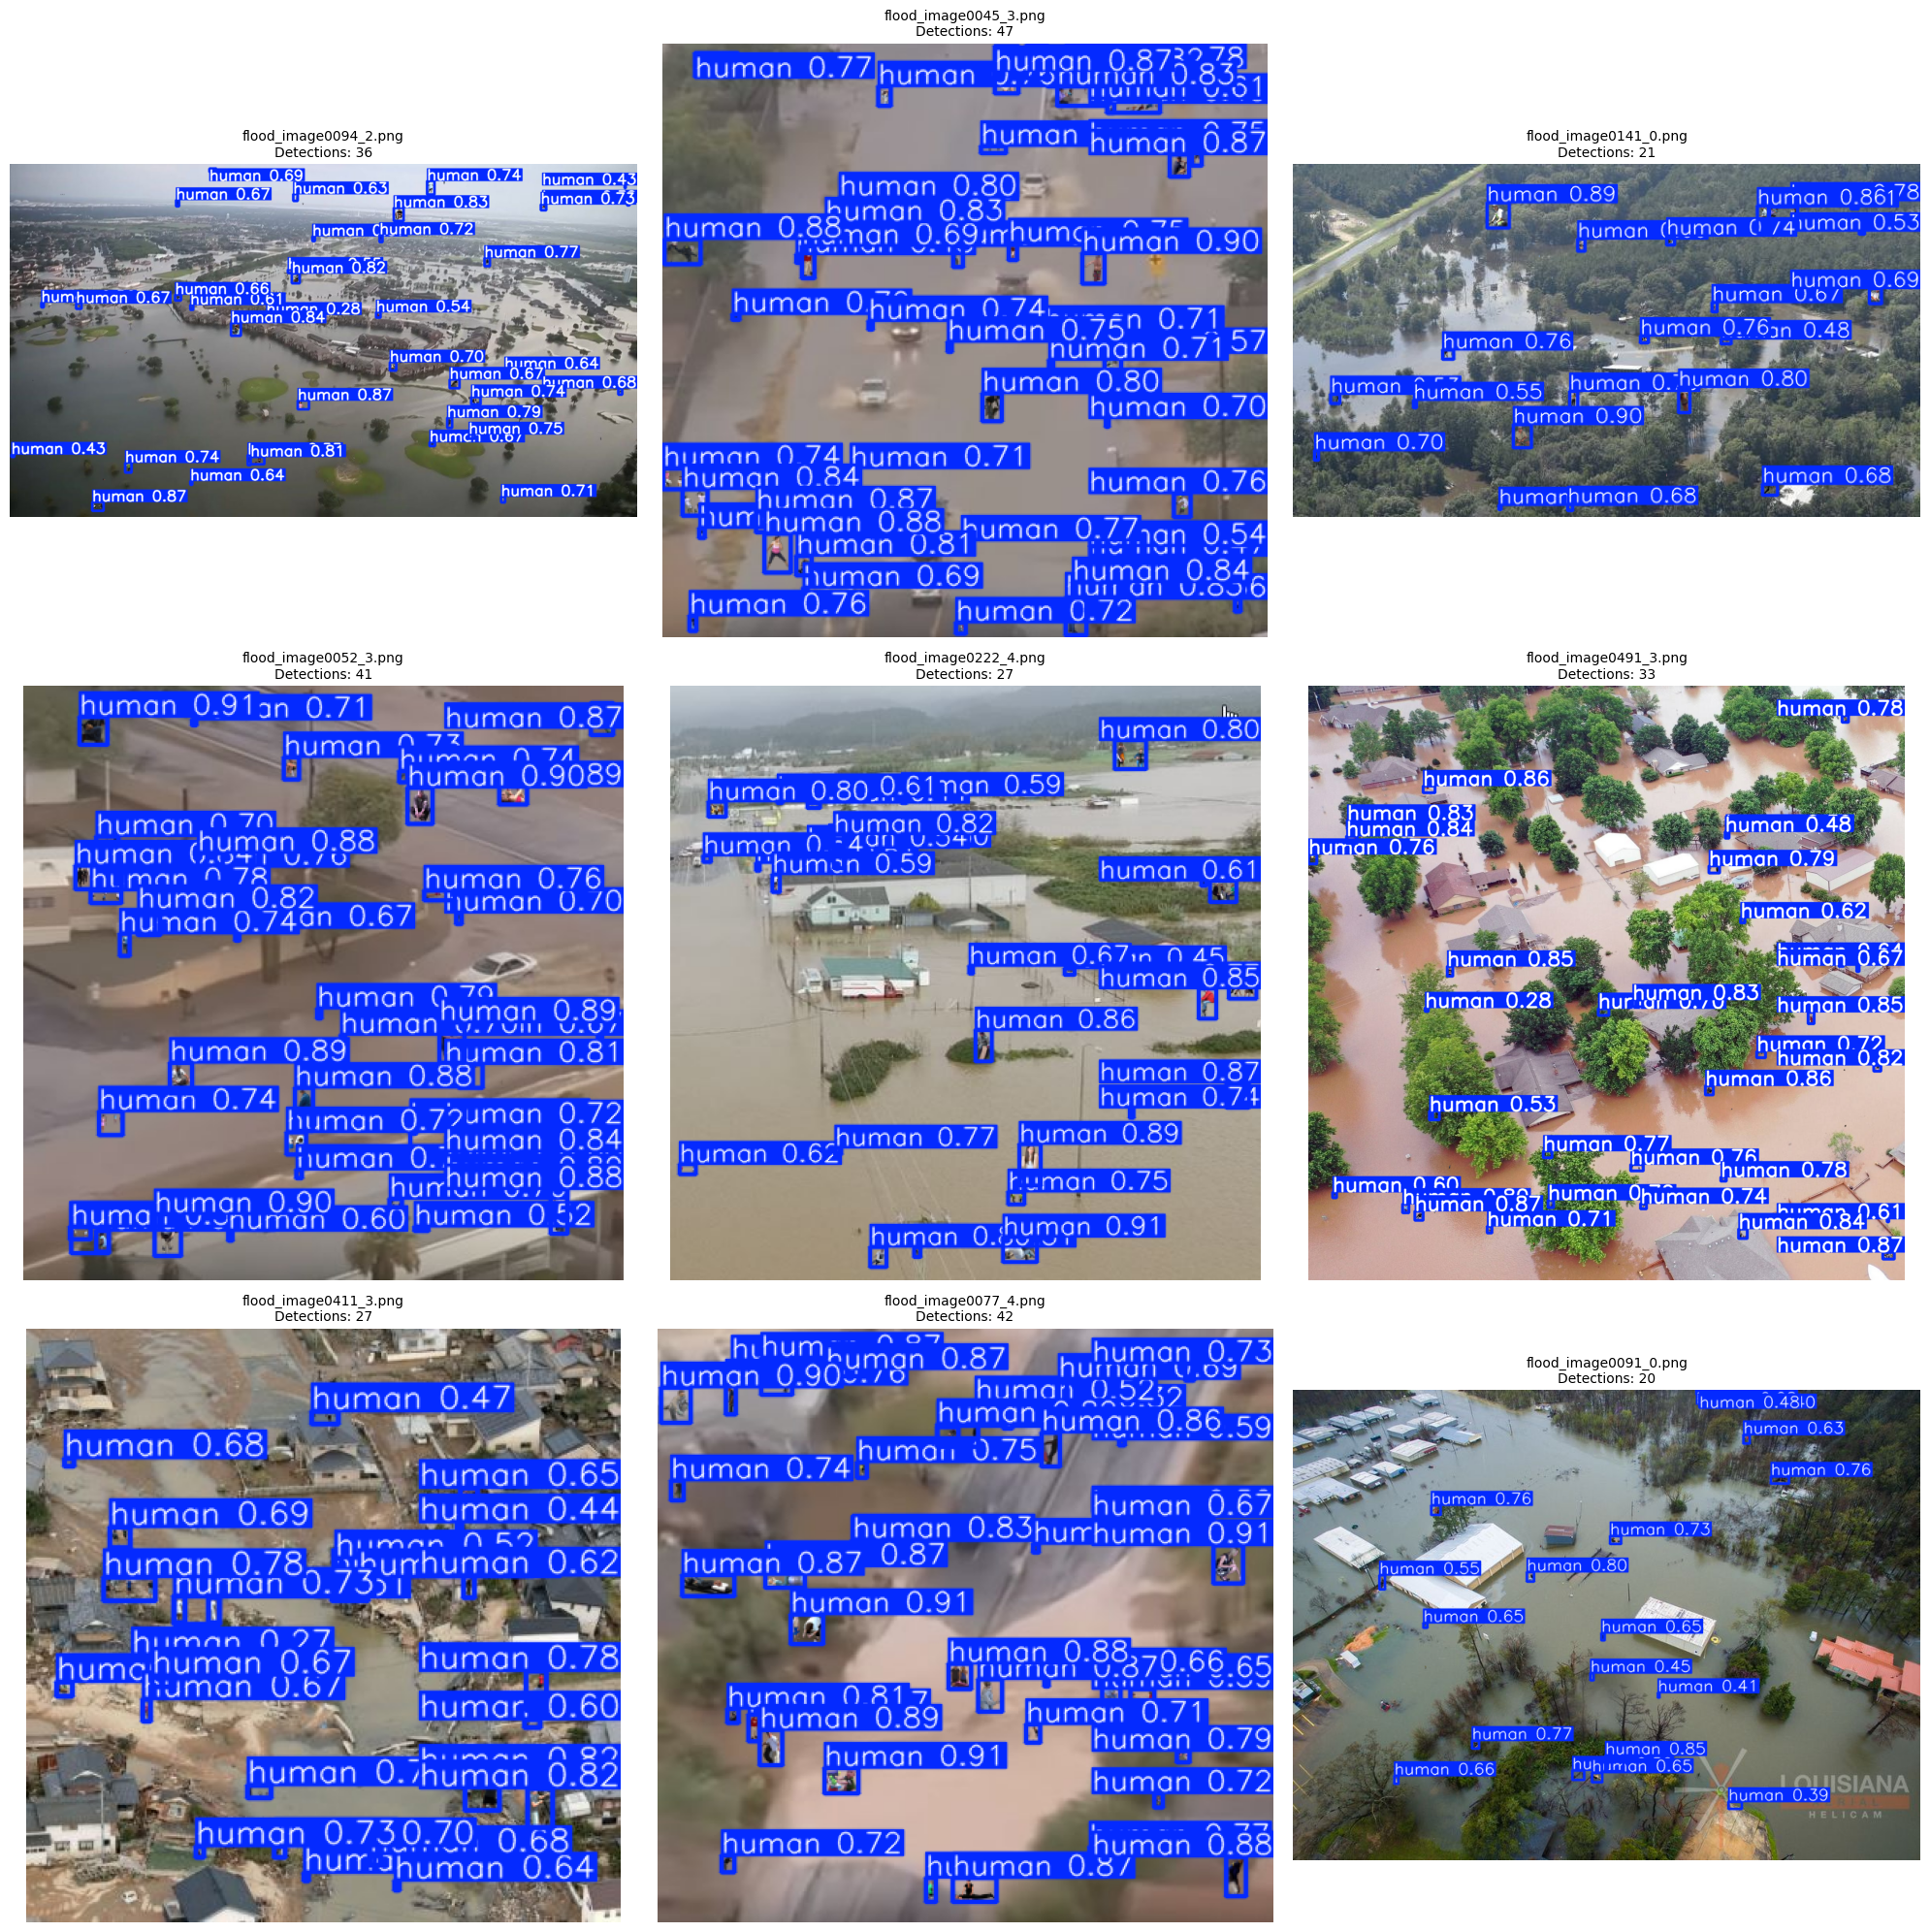

In [20]:
val_images_dir = work_dir / "images" / "val"
val_images = list(val_images_dir.glob('*.png')) + list(val_images_dir.glob('*.jpg'))
sample_imgs = random.sample(val_images, min(9, len(val_images)))

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

for idx, img_path in enumerate(sample_imgs):
    results = best_model.predict(
        source=str(img_path),
        conf=0.25,
        iou=0.45,
        imgsz=1280,
        verbose=False
    )

    plotted_img = results[0].plot()
    plotted_img = cv2.cvtColor(plotted_img, cv2.COLOR_BGR2RGB)

    num_detections = len(results[0].boxes)

    axes[idx].imshow(plotted_img)
    axes[idx].set_title(f"{img_path.name}\nDetections: {num_detections}", fontsize=10)
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('/content/validation_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. Confidence Threshold Analysis

Testing different confidence thresholds...

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3825.9±706.0 MB/s, size: 615.7 KB)
val: Scanning /content/flood_yolo/labels/val.cache... 542 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 542/542 1.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 68/68 4.7it/s 14.3s
                   all        542      18562      0.847      0.783      0.849      0.612
Speed: 2.4ms preprocess, 16.6ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /content/runs/detect/val2
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2302.8±427.7 MB/s, size: 724.7 KB)
val: Scanning /content/flood_yolo/labels/val.cache... 542 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 542/542 1.2Mit/s 0.0s
           

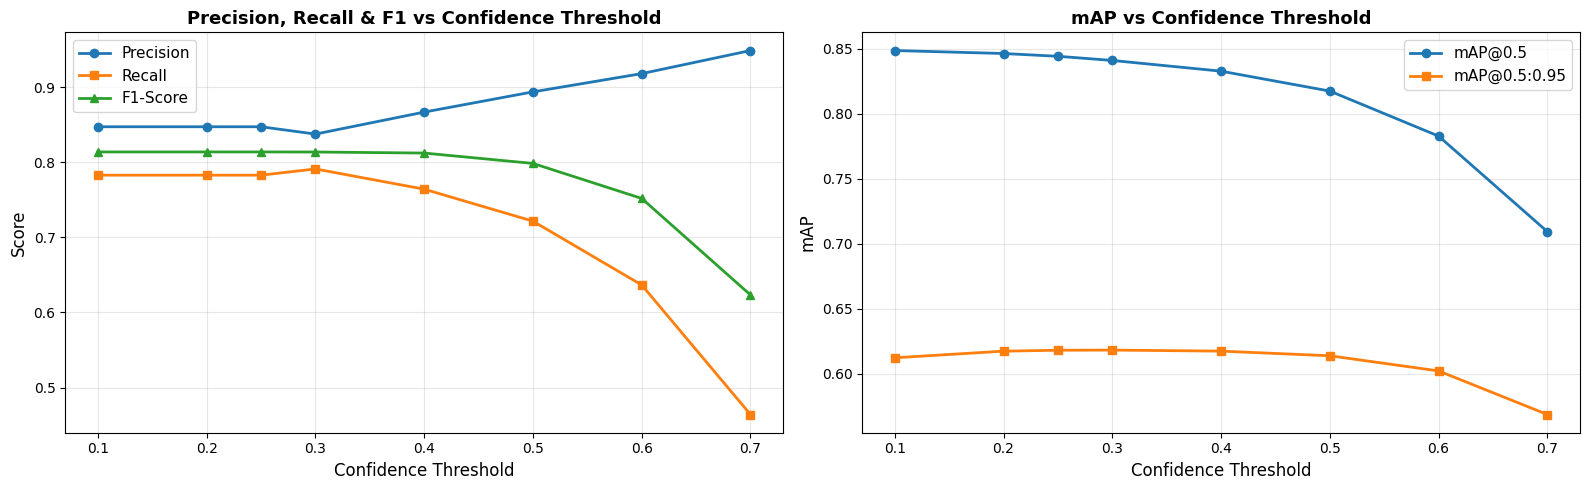


Optimal confidence threshold: 0.1
  F1-Score: 0.8137


In [21]:
conf_thresholds = [0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7]
threshold_metrics = []

print("Testing different confidence thresholds...\n")

for conf in conf_thresholds:
    val_res = best_model.val(
        data=str(yaml_path),
        split='val',
        imgsz=1280,
        batch=8,
        conf=conf,
        iou=0.6,
        verbose=False
    )

    threshold_metrics.append({
        'Confidence': conf,
        'Precision': val_res.box.mp,
        'Recall': val_res.box.mr,
        'mAP50': val_res.box.map50,
        'mAP50-95': val_res.box.map,
        'F1': 2 * (val_res.box.mp * val_res.box.mr) / (val_res.box.mp + val_res.box.mr + 1e-8)
    })

threshold_df = pd.DataFrame(threshold_metrics)
print(threshold_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(threshold_df['Confidence'], threshold_df['Precision'], 'o-', label='Precision', linewidth=2)
axes[0].plot(threshold_df['Confidence'], threshold_df['Recall'], 's-', label='Recall', linewidth=2)
axes[0].plot(threshold_df['Confidence'], threshold_df['F1'], '^-', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Confidence Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Precision, Recall & F1 vs Confidence Threshold', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(threshold_df['Confidence'], threshold_df['mAP50'], 'o-', label='mAP@0.5', linewidth=2)
axes[1].plot(threshold_df['Confidence'], threshold_df['mAP50-95'], 's-', label='mAP@0.5:0.95', linewidth=2)
axes[1].set_xlabel('Confidence Threshold', fontsize=12)
axes[1].set_ylabel('mAP', fontsize=12)
axes[1].set_title('mAP vs Confidence Threshold', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/confidence_threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

optimal_idx = threshold_df['F1'].idxmax()
optimal_conf = threshold_df.loc[optimal_idx, 'Confidence']
print(f"\nOptimal confidence threshold: {optimal_conf}")
print(f"  F1-Score: {threshold_df.loc[optimal_idx, 'F1']:.4f}")

## 12. Export Model

In [22]:
onnx_path = best_model.export(
    format='onnx',
    imgsz=1280,
    dynamic=True,
    simplify=True
)

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/content/flood_yolov11_best.pt' with input shape (1, 3, 1280, 1280) BCHW and output shape(s) (1, 5, 33600) (18.3 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 4.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.19.1 opset 22...
ONNX: slimming with onnxslim 0.1.72...
ONNX: export success ✅ 8.6s, saved as '/content/flood_yolov11_best.onnx' (36.5 MB)

Export complete (9.7s)
Results saved to /content
Predict:         yolo predict task=detect model=/content/flood_yolov11_best.onnx imgsz=1280  
Validate:        yolo val task=detect model=/content/f

## 13. Summary

In [23]:
print("\n" + "="*70)
print("  TRAINING SUMMARY")
print("="*70)
print(f"\n Dataset:")
print(f"   - Training images: {len(flood_train_imgs)}")
print(f"   - Validation images: {len(flood_val_imgs)}")
print(f"\n Model: YOLOv11x")
print(f"\n Best Performance:")
print(f"   - Precision: {val_results.box.mp:.4f}")
print(f"   - Recall: {val_results.box.mr:.4f}")
print(f"   - mAP@0.5: {val_results.box.map50:.4f}")
print(f"   - mAP@0.5:0.95: {val_results.box.map:.4f}")
print(f"\n Saved Models:")
print(f"   - PyTorch: {output_model_path}")
print(f"   - ONNX: {onnx_path}")
print(f"\n Recommended Inference Settings:")
print(f"   - Confidence threshold: {optimal_conf}")
print(f"   - IoU threshold: 0.45")
print(f"   - Image size: 1280")
print("\n" + "="*70)

print("\n Next Steps:")
print("   1. Test on real flood images")
print("   2. Fine-tune confidence threshold based on use case")
print("   3. Consider ensemble methods if needed")
print("   4. Deploy using ONNX or TensorRT for production")
print("   5. Monitor performance and retrain with new data")


  TRAINING SUMMARY

 Dataset:
   - Training images: 1529
   - Validation images: 542

 Model: YOLOv11x

 Best Performance:
   - Precision: 0.8472
   - Recall: 0.7827
   - mAP@0.5: 0.8326
   - mAP@0.5:0.95: 0.5613

 Saved Models:
   - PyTorch: /content/flood_yolov11_best.pt
   - ONNX: /content/flood_yolov11_best.onnx

 Recommended Inference Settings:
   - Confidence threshold: 0.1
   - IoU threshold: 0.45
   - Image size: 1280


 Next Steps:
   1. Test on real flood images
   2. Fine-tune confidence threshold based on use case
   3. Consider ensemble methods if needed
   4. Deploy using ONNX or TensorRT for production
   5. Monitor performance and retrain with new data
